# Veri Çekme ve Veriyi Kullanıma Hazırlama 

## Veri Çekme

In [1]:
import pandas as pd

In [2]:
from datasets import load_dataset 
import sys
import csv
maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
import warnings
warnings.filterwarnings('ignore')

Verilerimizi HuggingFaceden seçtik ve load_dataset fonksiyonuyla çektik

In [3]:
ds_interpress_news_category_tr_lite_train = load_dataset("interpress_news_category_tr_lite", split="train")
ds_interpress_news_category_tr_lite_test = load_dataset("interpress_news_category_tr_lite", split="test")

In [4]:
df_train_all = pd.DataFrame(ds_interpress_news_category_tr_lite_train)
df_test_all = pd.DataFrame(ds_interpress_news_category_tr_lite_test)

Çektiğimiz verileri pandas DataFramelere oturtarak işlemeye hazır hale getiriyoruz.

In [5]:
df_train_all.shape

(218880, 2)

In [6]:
df_test_all.shape

(54721, 2)

Veri miktarımız çok fazla olduğu için verileri işleme sürecinde sıkıntılar yaşadık o yüzden verilerimizin %10'nu alıp işlemlerimize decam edeceğiz.

In [7]:
df_train = df_train_all.head(21888)
df_test = df_test_all.head(5472)

In [8]:
df_train

,content,category
0,Tarihten Sınıfta Kaldık Bugün tarihe damgasını...,0
1,"clş ve yatırım ortamı iyileştiriliyor, bürokra...",1
2,Animasyon meraklıları için! Yönetmen: Jennifer...,0
3,İTİ BEEF JJ SVftSL ff 44 BEEFSFISH 16)2016...,0
4,LPG Dolum - Boşaltım kursu KTSO da yapıldı Kar...,1
...,...,...
21883,KİM MARKET 72. mağazasını Büyükçekmece de açtı...,1
21884,Uche ve Yasin bitti PTT 1. Lig ekiplerinden Ga...,5
21885,Korcan Cicinho Navratil Ümit Ziya Burhan Mehdi...,5
21886,Gölcükspor eski futbolcularını topladı 3. Lig ...,5


In [9]:
df_test

,content,category
0,50 yıldır yükselen enerji: Aygaz TÜRK HALKINI ...,1
1,Onur Akyıl Bir insan kadar mutsuzBir insan kad...,0
2,. yolculuk GÜNEYLİ SARIŞIN: REESE WITHERSPOON ...,0
3,Doğru tercih yapan hiçbir aday açıkta kalmayac...,3
4,De Jong için sıraya girdiler SERİE A ekipler...,5
...,...,...
5467,ARDAĞIN ZİRVESİNDE jj- Amasya Üniversitesi öğ...,0
5468,"Yıldız oyuncular Burası, Gıoyneth Paltroıo un ...",0
5469,KAYSERİ Yİ HER ZAMAN BEĞENİYORUZ Kayserini! ta...,0
5470,KÖŞE YAZARLARI Büyük veri devriminin evrimleşe...,6


In [10]:
train_categories = df_train.groupby('category')
print("Train Total Categories:", train_categories.ngroups)
print(train_categories.size())

Train Total Categories: 10
category
0    6985
1    3764
2    1026
3    1036
4     681
5    2352
6    3127
7     595
8    1873
9     449
dtype: int64


In [11]:
test_categories = df_test.groupby('category')
print("Test Total Categories:", test_categories.ngroups)
print(test_categories.size())

Test Total Categories: 10
category
0    1735
1     886
2     242
3     227
4     174
5     600
6     848
7     147
8     502
9     111
dtype: int64


### Verileri Görselleştirme

Veri setimizdeki verilerin kategorik dağılımını görselleştiriyoruz.

In [12]:
import matplotlib.pyplot as plt

<Axes: ylabel='count'>

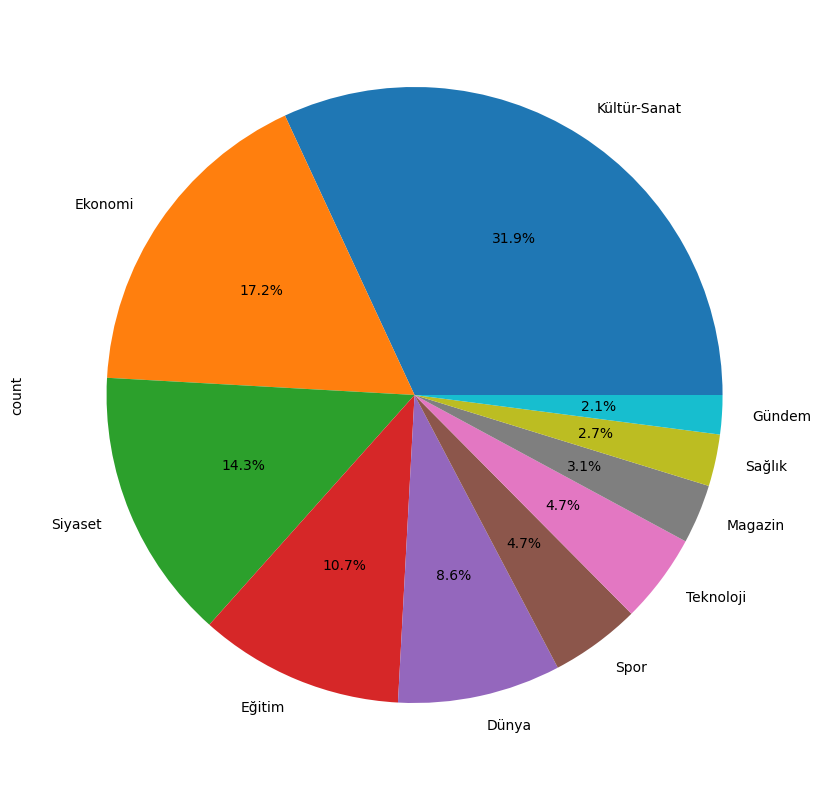

In [13]:
labels = ["Kültür-Sanat", "Ekonomi", "Siyaset", "Eğitim", "Dünya", "Spor", "Teknoloji", "Magazin", "Sağlık", "Gündem"]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
df_train['category'].value_counts().plot.pie(autopct = '%1.1f%%', labels=labels)

# Veri Hazırlığı

### PATH_STOPWORDS_TR

Bu değişken, Türkçe durdurma kelimeleri (metin işlemede sıklıkla filtrelenen yaygın kelimeler) içeren bir dosyanın yolunu depolar. .pkl dosya uzantısı, bunun bir salamura veri dosyası olduğunu gösterir.

### PATH_BLACKLIST_TR

Bu değişken, Türkçe metne özgü engellenmiş kelimeler (bazı nedenlerden dolayı dışarıda bırakılması gereken kelimeler) içeren bir dosyanın yolunu depolar. Yine, .pkl uzantısı, bunun bir salamura veri dosyası olduğunu gösterir.

In [14]:
import re
import string
import pickle
from collections import defaultdict

PATH_STOPWORDS_TR = 'data/stopwords_tr_interpress.pkl'
PATH_BLACKLIST_TR = 'data/tr-blacklist.pkl'

## Temizleme Fonksiyonları

Bu fonksiyonlar, Türkçe metinleri çeşitli açılardan temizlemek için kapsamlı bir araç seti sunar. Durdurma kelimeleri, kara liste kelimeleri, URL'ler,
e-posta adresleri, noktalama işaretleri, sayılar, ek takılar gibi istenmeyen öğeleri metinden kaldırarak daha temiz ve işlenebilir bir metin elde etmeyi sağlar. Her fonksiyon belirli bir amaca hizmet eder ve birlikte kullanıldığında metin ön işleme ve temizleme işlemlerinde oldukça faydalı olabilirler.

In [15]:
#  load stopwords
def get_stopwords():
    try:
        with open(PATH_STOPWORDS_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))

#  load blacklist
def get_blacklist():
    try:
        with open(PATH_BLACKLIST_TR, 'rb') as data_file:
            return pickle.load(data_file)
    except IOError as exc:
        raise IOError("No such stopwords file! Error: " + str(exc))

#  cleaning stopwords
def clean_stopwords(content):
    # content: str
    content = content.split(" ")
    filtered_list = []
    stopwords = get_stopwords()
    for word in content:
        if word not in stopwords:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

#  cleaning blacklist
def clean_blacklist(content):
    # content: str
    # return: str
    content = content.split(" ")
    filtered_list = []
    blacklist = get_blacklist()
    for word in content:
        if word not in blacklist:
            filtered_list.append(word)

    text = ' '.join(filtered_list)
    return text

1. get_stopwords ve get_blacklist:

Her ikisi de önceden kaydedilmiş dosyalardan verileri yükler. 
get_stopwords fonksiyonu, Türkçe metinlerinde sıklıkla kullanılan ve anlamsız sayılabilecek kelimeleri içeren bir dosyadan (PATH_STOPWORDS_TR) verileri yükler.
Bu kelimeler, stopwords olarak adlandırılır. get_blacklist fonksiyonu ise Türkçe metinlerinde istenmeyen kelimeleri içeren bir dosyadan (PATH_BLACKLIST_TR) verileri yükler.
Bu kelimeler, kara liste olarak adlandırılır. Her iki fonksiyon da veri yükleme işlemi sırasında hata oluşursa bir istisna fırlatır.

2. clean_stopwords:

Bu fonksiyon bir metin alır (content) ve get_stopwords fonksiyonundan yüklediği durdurma kelimelerini (stopwords) kullanarak metni temizler. Metni boşluklara göre ayırır (split), ardından her kelimeyi durdurma kelimeleri listesinde arar. Eğer kelime listede değilse, temizlenen metin listesine (filtered_list) eklenir. Son olarak, temizlenen metin listesini tekrar birleştirir (join) ve döndürür.

3. clean_blacklist:

clean_stopwords fonksiyonuna benzer şekilde clean_blacklist fonksiyonu da bir metin alır (content) ve get_blacklist fonksiyonundan yüklediği kara liste kelimelerini kullanarak metni temizler. Metni boşluklara göre ayırır, her kelimeyi kara listede arar ve kara listede olmayan kelimeleri temizlenen metin listesine ekler. Son olarak, temizlenen metin listesini birleştirir ve döndürür.

In [16]:
#  cleaning URLs
def clean_url(content):
    reg_url = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    pattern_url = re.compile(reg_url)
    content = pattern_url.sub('',content)
    return content

"""
Bu fonksiyon bir metin alır (content) ve metindeki URL'leri temizler.
Düzenli ifadeler (re) kütüphanesini kullanarak URL kalıplarını tanımlar ve metindeki bu kalıpları boş bir ifade ile değiştirir.
Böylece metinden URL'ler silinmiş olur.
"""
    
#  cleaning e-mails
def clean_email(content):
    reg_email='\S*@\S*\s?'
    pattern_email = re.compile(reg_email)
    content = pattern_email.sub('',content)
    return content

"""
clean_email fonksiyonu da re kütüphanesini kullanarak bir metindeki (content) e-posta adreslerini temizler.
E-posta adresi kalıplarını tanımlayan bir düzenli ifade kullanır ve metindeki bu kalıpları boş bir ifade ile değiştirir.
"""
    
#  cleaning punctuation
def clean_punctuation(content):
    #regex = re.compile('[%s]' % re.escape(string.punctuation))
    #content = regex.sub(" ", content)
    content = content.translate(content.maketrans("", "", string.punctuation))
    return content

"""
Bu fonksiyon bir metin alır (content) ve metindeki noktalama işaretlerini temizler. İki yöntem kullanılabilir:

string.punctuation modülünü kullanarak noktalama işaretlerinin bir karakter dizisi oluşturulur ve translate metodu ile metindeki noktalama işaretleri boşluklara dönüştürülür.
Yorum satırında belirtildiği gibi, re.compile ile noktalama işaretlerini tanımlayan bir düzenli ifade oluşturulabilir ve sub metodu ile metindeki noktalama işaretleri boşluklara dönüştürülür.
"""
    
#  cleaning digits
def clean_numbers(content):
    remove_digits = str.maketrans('', '', string.digits)
    text = content.translate(remove_digits)
    return text

"""
clean_numbers fonksiyonu bir metin alır (content) ve metindeki sayıları temizler.
string.digits modülünü kullanarak rakamların bir karakter dizisi oluşturulur ve translate metodu ile metindeki rakamlar boşluklara dönüştürülür.
"""

def listToString(text):
    #  text: string
    #  return: string 
    str1 = " "  
    return (str1.join(text)) 

"""
Bu fonksiyon bir metin listesi alır (text) ve liste elemanlarını boşluk ekleyerek birleştirir. Sonuç olarak, boşluklarla ayrılmış bir metin döndürür.
"""

#  cleaning postfix
def clean_postfix(content):
    #  content: list
    #  return: str
    spesific_punctation = [39, 8217] # ascii codes of spesific punctations
    all_words = defaultdict(list)
    counter = 0
    for i, word in enumerate(content):
        if len(word) > 2:
            if chr(8217) in word:
                replaced_word = word.replace(chr(8217), " ")  #  clean for ’
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            elif chr(39) in word:
                replaced_word = word.replace(chr(39), " ")  # clean for '
                replaced_word = replaced_word.split(" ")[0]
                all_words[i].append(replaced_word)
            else:
                all_words[i].append(word)
    all_words = sorted(all_words.items())

    text = ""
    for i in range(len(all_words)):
        text = text + " " + all_words[i][1][0]

    return text

"""
Bu fonksiyon biraz daha karmaşık. Bir metin listesi alır (content) ve Türkçe metinlerde sık karşılaşılan ek takıları (Venezuela'nın gibi) temizler.
Belirli noktalama işaretlerinin (', ’) ascii kodlarını kullanarak kelimeleri ayırır ve ek takıları siler.
Son olarak, temizlenen kelimeleri bir cümle olarak birleştirir ve döndürür.
"""

def clean_text(content):
    #  text: string
    #  return: string
    content = content.lower()
    cleaned_email = clean_email(content)
    cleaned_email_url = clean_url(cleaned_email)
    cleaned_email_url = listToString(cleaned_email_url.split("."))
    cleaned_email_url = cleaned_email_url.split(" ")
    cleaned_email_url_postfix = clean_postfix(cleaned_email_url)
    cleaned_email_url_postfix_punctuation = clean_punctuation(cleaned_email_url_postfix)
    cleaned_email_url_postfix_punctuation_numbers = clean_numbers(cleaned_email_url_postfix_punctuation)
    cleaned_email_url_postfix_punctuation_numbers_stopwords = clean_stopwords(cleaned_email_url_postfix_punctuation_numbers)
    cleaned_email_url_postfix_punctuation_numbers_stopwords_blacklist = clean_blacklist(cleaned_email_url_postfix_punctuation_numbers_stopwords)

    filtered_sentence = []
    for word in cleaned_email_url_postfix_punctuation_numbers_stopwords_blacklist.split(" "):
        if len(word) > 2:
            filtered_sentence.append(word)
    
    text = ' '.join(filtered_sentence)
    return text
"""
Bu fonksiyon, metin temizleme işleminin ana fonksiyonudur.
Bir metin alır (content) ve çeşitli temizleme adımlarından geçirir.
Öncelikle metni küçük harfe çevirir (lower).
"""
    
    

'\nBu fonksiyon, metin temizleme işleminin ana fonksiyonudur.\nBir metin alır (content) ve çeşitli temizleme adımlarından geçirir.\nÖncelikle metni küçük harfe çevirir (lower).\n'

In [17]:
df_train.content[1265]

'CAJA SINAVI YARIN -#% BEŞİKTAŞ Erkek Basketbol f Takımı, THY Euroleague de yarın Caja Laboral ile karşılaşacak. Siyah-beyazlılar, grubun 10. maçında saat 20.00 de Abdi İpekçi Arena da Caja Laboral ı ağırlayacak. Beşiktaş ın TOP 16 F Grubu nda oynadığı 9 karşılaşmada henüz galibiyeti bulunmazken, Caja nın 9 maçta 4 zaferi var.'

In [18]:
labels[df_train.category[1265]]

'Spor'

In [19]:
clean_text(df_train.content[1265])

'caja sinavi yarin beşi̇ktaş erkek basketbol takımı thy euroleague yarın caja laboral karşılaşacak siyahbeyazlılar grubun maçında abdi i̇pekçi arena caja laboral ağırlayacak beşiktaş top grubu nda oynadığı karşılaşmada galibiyeti bulunmazken caja maçta zaferi'

Clean_text fonksiyonunu tüm veri setimize uygulayarak temizlenmiş yeni veriyi DataFrame'mimize yeni sütün olarak ekliyoruz ve ilerideki işlemlerimizi bu temizlenmiş veri üzerinden gideceğiz.

## Veri Temizleme

In [20]:
cleaning = lambda x: clean_text(x)
df_train['clean_content'] = df_train['content'].apply(cleaning)

In [21]:
df_train

,content,category,clean_content
0,Tarihten Sınıfta Kaldık Bugün tarihe damgasını...,0,tarihten sınıfta kaldık bugün tarihe damgasını...
1,"clş ve yatırım ortamı iyileştiriliyor, bürokra...",1,clş yatırım ortamı iyileştiriliyor bürokrasi a...
2,Animasyon meraklıları için! Yönetmen: Jennifer...,0,animasyon meraklıları yönetmen jenniferyuh ses...
3,İTİ BEEF JJ SVftSL ff 44 BEEFSFISH 16)2016...,0,i̇ti̇ beef svftsl beefsfish kirmizi eti̇n fran...
4,LPG Dolum - Boşaltım kursu KTSO da yapıldı Kar...,1,lpg dolum boşaltım kursu ktso yapıldı karaman ...
...,...,...,...
21883,KİM MARKET 72. mağazasını Büyükçekmece de açtı...,1,ki̇m market mağazasını büyükçekmece açtı marke...
21884,Uche ve Yasin bitti PTT 1. Lig ekiplerinden Ga...,5,uche yasin bitti ptt lig ekiplerinden gaziante...
21885,Korcan Cicinho Navratil Ümit Ziya Burhan Mehdi...,5,korcan cicinho navratil ümit ziya burhan mehdi...
21886,Gölcükspor eski futbolcularını topladı 3. Lig ...,5,gölcükspor eski futbolcularını topladı lig tem...


In [22]:
df_test['clean_content'] = df_test['content'].apply(cleaning)

In [23]:
df_test

,content,category,clean_content
0,50 yıldır yükselen enerji: Aygaz TÜRK HALKINI ...,1,yıldır yükselen enerji aygaz türk halkini tüpg...
1,Onur Akyıl Bir insan kadar mutsuzBir insan kad...,0,onur akyıl insan mutsuzbir insan mutsuzi onur ...
2,. yolculuk GÜNEYLİ SARIŞIN: REESE WITHERSPOON ...,0,yolculuk güneyli̇ sarişin reese witherspoon ya...
3,Doğru tercih yapan hiçbir aday açıkta kalmayac...,3,doğru tercih yapan aday açıkta kalmayacak aday...
4,De Jong için sıraya girdiler SERİE A ekipler...,5,jong sıraya girdiler seri̇e ekiplerinden lan b...
...,...,...,...
5467,ARDAĞIN ZİRVESİNDE jj- Amasya Üniversitesi öğ...,0,ardağin zi̇rvesi̇nde amasya üniversitesi öğren...
5468,"Yıldız oyuncular Burası, Gıoyneth Paltroıo un ...",0,yıldız oyuncular burası gıoyneth paltroıo hala...
5469,KAYSERİ Yİ HER ZAMAN BEĞENİYORUZ Kayserini! ta...,0,kayseri̇ yi̇ zaman beğeni̇yoruz kayserini tari...
5470,KÖŞE YAZARLARI Büyük veri devriminin evrimleşe...,6,köşe yazarlari büyük veri devriminin evrimleşe...


## Temizlenmiş Verilerimizi Pickle Formatında Kaydediyoruz

In [24]:
df_train.to_pickle('data/news_tr_train_cleaned.pkl')
df_test.to_pickle('data/news_tr_test_cleaned.pkl')